In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve

Define the function to compute the kernel given the weights and the degree of the polynomial

In [2]:
def compute_LPA_kernel(w, N):
    # compute the LPA kernel for a given weights and polynomial degree
    # input:
    #   w: vector containing the weights for the local LS problem
    #   N: degree of the polynomial approximation
    # return:
    #   g: the computed LPA kernel

    # filter size equal to the number of weights
    M = w.shape[0]

    # generate the inverse of weights
    winv = 1/w

    # set to zero weights that are inf
    winv = np.where(np.isinf(winv), 0, winv)

    # define the weight matrix
    W = np.diag(w)
    Winv = np.diag(winv)

    # define the matrix T containing the polynomials sampled over the window
    t = np.linspace(0, 1, M)
    T = np.vander(t, N+1, increasing=True)

    # Construct the LPA kernel
    # compute the qr decomposition of WT
    Q, R = np.linalg.qr(W @ T)

    # define Qtilde
    Qtilde = Winv @ Q

    # adjust Qtilde with the weights matrix squared
    W2Qtilde = W**2 @ Qtilde

    # select the central row of W2Qtilde
    central_row_index = int(W2Qtilde.shape[0]/2)
    W2Qtilde_central_row = W2Qtilde[central_row_index, :]

    # compute the kernel
    g = W2Qtilde_central_row @ Q.T

    # flipping, since it is used in convolution
    g = np.flip(g)

    return g


LPA-ICI
-------
Set the LPA-ICI parameters

In [3]:
# maximum degree of polynomial used for fitting
N = 5

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 51
all_h = np.arange(1, hmax+1)

Generate the signal

Text(0.5, 1.0, 'Input Signal')

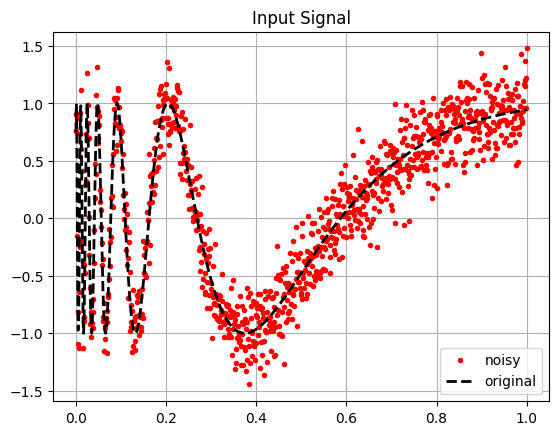

In [4]:
LENGTH = 1000

ty = np.linspace(0, 1, LENGTH)
y = np.sin(2 / (ty + 0.05))

#  noise standard deviation
sigma = 0.2

# noisy signal
s = y + sigma*np.random.normal(size=LENGTH)


plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Generate the LPA kernels for all the scale. Use centered weights.


In [5]:
all_g = []
for i in range(len(all_h)):
    # define the weights for the scale h (symmetric, left or right)
    size = 2*all_h[i] - 1
    w = np.ones(size)

    # compute and store the kernel g
    # TODO: implement the function compute_LPA_kernel
    g = compute_LPA_kernel(w, N)

    all_g.append(g)

Initialize all the variables for the ICI rule

In [6]:
# initialize the estimate
yhat = np.zeros(LENGTH)

# initialize the vector containing the best scale for each sample
best_scale = np.zeros(LENGTH)

# initialize the lower and upper bound vectors
lower_bounds = -np.inf*np.ones(LENGTH)
upper_bounds =  np.inf*np.ones(LENGTH)

Loop over all the scales

In [7]:
for i, h in enumerate(all_h):
    g = all_g[i]

    # compute the estimate for the scale h
    yhat_h = convolve(s, g, mode='same')

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma*sigma*np.linalg.norm(g)
    ub = yhat_h + Gamma*sigma*np.linalg.norm(g)

    # update the lower and upper bounds
    lower_bounds = np.maximum(lower_bounds, lb)
    upper_bounds = np.maximum(upper_bounds, ub)

    # identify for which samples h is the best scale according to the
    # ICI rule and update the best_scale vector accordingly
    best_scale[lower_bounds < upper_bounds] = h

    # update the estimate
    yhat[lower_bounds < upper_bounds] = yhat_h[lower_bounds < upper_bounds]

Use the best scale for each sample to compute the final estimates



In [8]:
yhat_final = yhat

/tmp/ipython-input-3677056126.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m-" (-> color='m'). The keyword argument will take precedence.
  ax[0].plot(ty, yhat_final, 'm-', linewidth=3, color = 'blue')


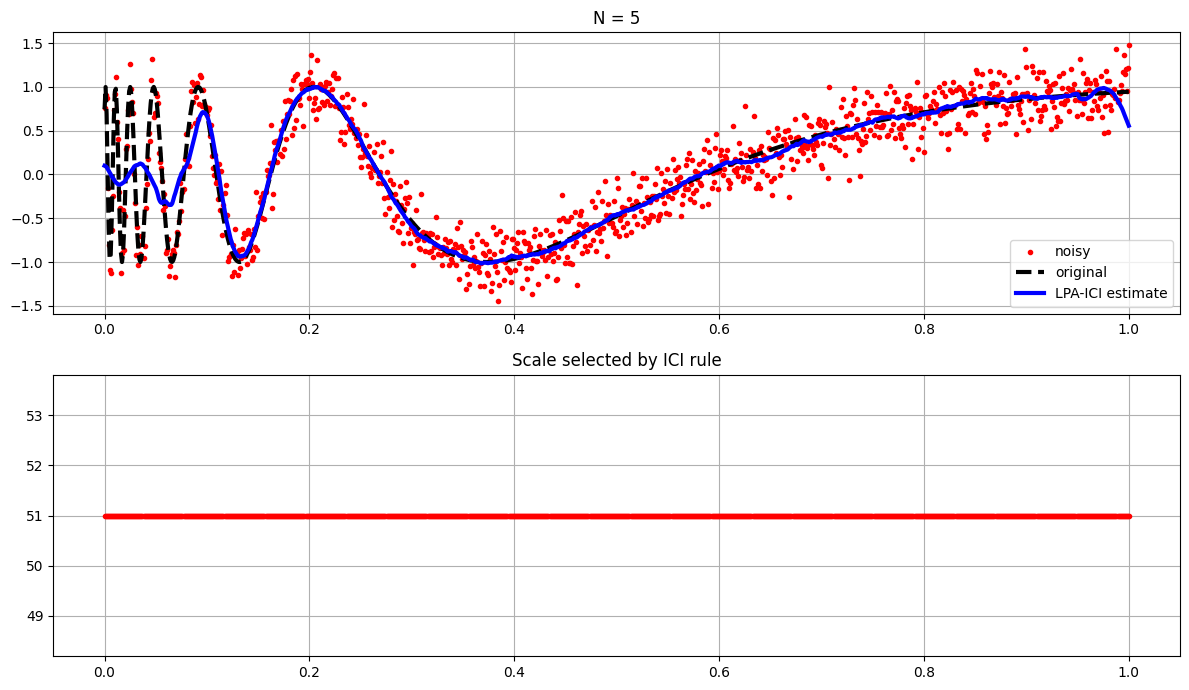

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (12,7))
ax[0].plot(ty, s, 'r.')
ax[0].plot(ty, y, 'k--', linewidth=3)
ax[0].plot(ty, yhat_final, 'm-', linewidth=3, color = 'blue')
ax[0].grid()
ax[0].legend(['noisy', 'original', 'LPA-ICI estimate'])
ax[0].set_title(f'N = {N:d}')

ax[1].plot(ty, best_scale, 'r.')
ax[1].set_title('Scale selected by ICI rule')
ax[1].grid()

fig.tight_layout()
plt.show()

LPA-ICI with Aggregation
------------------------
Set the parameters


In [10]:
# maximum degree of polynomial used for fitting
N = 1

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 51
all_h = np.arange(1, hmax+1)

Generate synthetic signal signal

Text(0.5, 1.0, 'Input Signal')

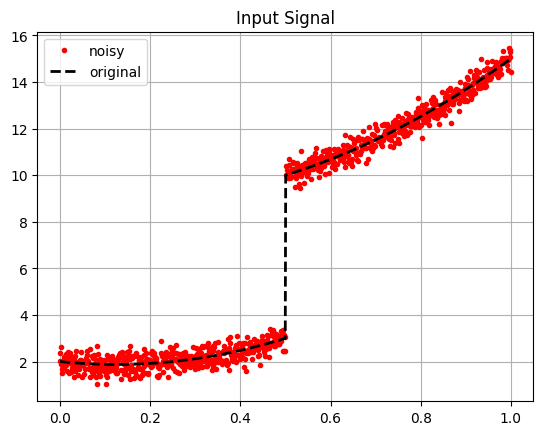

In [11]:
LENGTH = 1000
ty = np.linspace(0, 1, LENGTH)
y = 8 * ty ** 2 - 2*ty + 2
y[ty >0.5] = y[ty >0.5] + 7

#  noise standard deviation
sigma = 0.3

# noisy signal
s = y + sigma*np.random.normal(size=LENGTH)


plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Generate the LPA kernels for all the scale for both left and right windows

In [12]:
all_g_left = []
all_g_right = []

for i, h in enumerate(all_h):
    # define the weights for the scale h (left)
    # half filter size
    size = 2*h - 1
    HFS = int((size-1)/2)
    w = np.zeros(size)

    wl = w.copy()
    wl[:HFS+1] = 1
    g_left = compute_LPA_kernel(wl, N)
    all_g_left.append(g_left)

    # define the weights for the scale h (right)
    wr = w.copy()
    wr[-HFS-1:] = 1
    g_right = compute_LPA_kernel(wr, N)
    all_g_right.append(g_right)

/tmp/ipython-input-2876877992.py:13: RuntimeWarning: divide by zero encountered in divide
  winv = 1/w


Use the LPA-ICI to compute the estimate based on the **left** kernels

In [13]:
# initialize the left estimate
yhat_left = np.zeros(LENGTH)

# initialize the lower and upper bound vectors
lower_bounds = -np.inf*np.ones(LENGTH)
upper_bounds = np.inf*np.ones(LENGTH)

# intialize the vector containing the variance of the estimator for each sample
var_left = np.zeros(LENGTH)

for i, h in enumerate(all_h):
    g_l = all_g_left[i]

    # compute the estimate for the scale h
    yhat_h = convolve(s, g_l, 'same')

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma*sigma*np.linalg.norm(g_l)
    ub = yhat_h + Gamma*sigma*np.linalg.norm(g_l)

    # update the lower and upper bounds
    lower_bounds = np.maximum(lower_bounds, lb)
    upper_bounds = np.minimum(upper_bounds, ub)

    # update the estimate
    yhat_left[lower_bounds < upper_bounds] = yhat_h[lower_bounds < upper_bounds]

    # update the variance
    var_left[lower_bounds < upper_bounds] = sigma**2 * np.linalg.norm(g_l)**2

Use the LPA-ICI to compute the estimate based on the **right** kernels

In [14]:
# initialize the right estimate
yhat_right = np.zeros(LENGTH)

# initialize the lower and upper bound vectors
lower_bounds = -np.inf*np.ones(LENGTH)
upper_bounds = np.inf*np.ones(LENGTH)

# intialize the vector containing the variance of the estimator for each sample
var_right = np.zeros(LENGTH)

for i, h in enumerate(all_h):
    g_r = all_g_right[i]

    # compute the estimate for the scale h
    yhat_h = convolve(s, g_r, 'same')

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma*sigma*np.linalg.norm(g_r)
    ub = yhat_h + Gamma*sigma*np.linalg.norm(g_r)

    # update the lower and upper bounds
    lower_bounds = np.maximum(lower_bounds, lb)
    upper_bounds = np.minimum(upper_bounds, ub)

    # update the estimate
    yhat_right[lower_bounds < upper_bounds] = yhat_h[lower_bounds < upper_bounds]

    # update the variance
    var_right[lower_bounds < upper_bounds] = sigma**2 * np.linalg.norm(g_r)**2

Perform the aggregation


In [15]:
wright = (1 / var_right)
wleft = (1 / var_left)
yhat_aggr = ((wright * yhat_right) + (wleft * yhat_left)) / (wright + wleft)

Text(0.5, 1.0, 'N = 1')

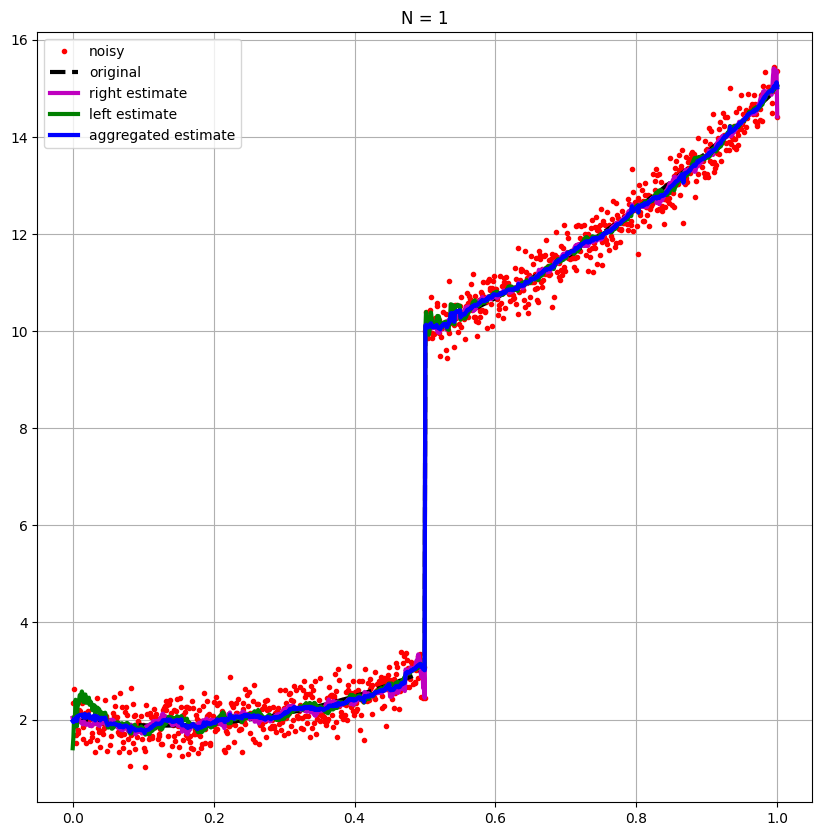

In [16]:
plt.figure(figsize=(10,10))
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, yhat_right, 'm-', linewidth=3)
plt.plot(ty, yhat_left, 'g-', linewidth=3)
plt.plot(ty, yhat_aggr, 'b-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'right estimate', 'left estimate', 'aggregated estimate'])
plt.title(f'N = {N:d}')
